### IMPORTS

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import layers, models
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### SETTING THE DATASET PATH

In [2]:
## TYPES OF PRE-PROCESSED DS AVAILABLE:
D1_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D1/"
D1_LINEAR_GAUSIAN_227px = "D://227px_LI_GB_D1/"
D2_LINEAR_GAUSIAN_227px = "D://227px_LI_GB_D2/"
D2_LINEAR_GAUSIAN_250px = "D://250px_LI_GB_D2/"
D1_AREA_GAUSIAN_227px = "D://227px_AI_GB_D1/"
D1_AREA_GAUSIAN_250px = "D://250px_AI_GB_D1/"
D1_D2_MIXED_250px = "D://D1_D2_MIXED_250px/"
## ^ DATASET.NO_INTERPOLATION_BLUR-FILTER_IMG-SIZE ^

#SELECTING DATASET

ds_type = D1_LINEAR_GAUSIAN_250px
input_size = 250
input_dim = 3

#SETTING THE PATH
dataset_path = signature_types = os.listdir(ds_type)
# print(signature_types)

In [3]:
print("Types of signatures: ", len(dataset_path))

Types of signatures:  2


In [4]:
signs = []
for item in signature_types:
  all_signs = os.listdir(ds_type+"/"+item)
  for sign in all_signs:
    if sign.endswith(".db"):
      pass
    else: 
      signs.append((item, str(ds_type+"/"+item) + "/" + sign))
print(signs)

[('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_1.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_10.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_11.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_12.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_13.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_14.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_15.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_16.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_17.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_18.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_19.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_2.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_20.png.png'), ('forgeries', 'D://250px_LI_GB_D1//forgeries/forgeries_10_21.png.

In [5]:
signs_df = pd.DataFrame(data = signs, columns = ["sign type", "image"])
print(signs_df.head())

   sign type                                              image
0  forgeries  D://250px_LI_GB_D1//forgeries/forgeries_10_1.p...
1  forgeries  D://250px_LI_GB_D1//forgeries/forgeries_10_10....
2  forgeries  D://250px_LI_GB_D1//forgeries/forgeries_10_11....
3  forgeries  D://250px_LI_GB_D1//forgeries/forgeries_10_12....
4  forgeries  D://250px_LI_GB_D1//forgeries/forgeries_10_13....


In [6]:
print("Total number of signs in the dataset: ", len(signs_df))

Total number of signs in the dataset:  2640


In [7]:
sign_count = signs_df["sign type"].value_counts()
print("Signatures in each category:")
print(sign_count)

Signatures in each category:
forgeries    1320
genuine      1320
Name: sign type, dtype: int64


### CREATING LIST ARRAY OF IMAGES WITH LABELS

In [8]:
images = []
labels = []
for i in signature_types:
  data_path = ds_type + str(i)
  filenames = [i for i in os.listdir(data_path)]
  for f in tqdm(filenames, desc=f"Processing {i}"):
    if f.endswith(".db"):
      pass
    else:
      img = cv2.imread(data_path + "/" + f)
      images.append(img)
      labels.append(i)

Processing genuine: 100%|██████████| 1320/1320 [00:01<00:00, 1066.96it/s]


### PLOTTING IMG BEFORE & AFTER PRE-PROCESSING

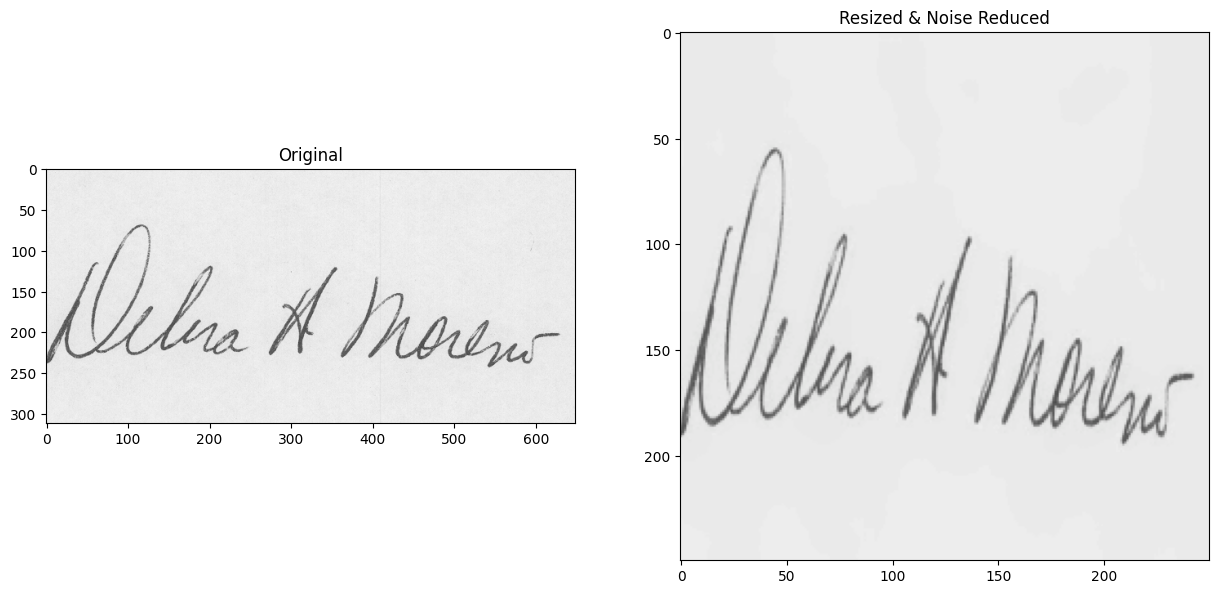

In [9]:
img_og = cv2.imread("D://cedar_original//full_org/original_9_9.png")
img_pp = cv2.imread('D://250px_AI_GB_D1//genuine/original_9_9.png.png')
fig, ax = plt.subplots(ncols=2, figsize=(15,10))
_counter = 0
for idx, img in enumerate([img_og, img_pp]):
    ax[idx].imshow(img.astype(int))
    if _counter == 0:
        ax[idx].set_title("Original")
        _counter += 1
    else:
        ax[idx].set_title("Resized & Noise Reduced")

In [10]:
images = np.array(images)
images = images.astype('float32') / 255.0

In [11]:
y = signs_df['sign type'].values
y = y.reshape(-1,1)
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
Y=np.array(columnTransformer.fit_transform(y),dtype='float32')
# print(Y.shape)

### SPLITTING THE DATASET (80 : 20)

In [12]:
images, Y = shuffle(images,Y,random_state=1)
train_x,test_x,train_y,test_y = train_test_split(images, Y, test_size=0.2, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)
train_x = train_x / 255.0
test_x = test_x / 255.0

(2112, 250, 250, 3)
(528, 250, 250, 3)
(2112, 2)
(528, 2)


### PROPOSED CNN MODEL (based on ijerph)

In [13]:
## This CNN does not work with image size < 240px
cnn = models.Sequential([
     layers.Conv2D(filters=32, kernel_size=(3, 3), activation= 'relu', input_shape=(input_size, input_size, input_dim)),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     # layers.Conv2D(filters=32, kernel_size=(3, 3), activation= 'relu'),
     # layers.MaxPooling2D((2, 2)),
     # layers.BatchNormalization(),
     layers.Conv2D(filters=64, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     # layers.Conv2D(filters=64, kernel_size=(3, 3), activation= 'relu'),
     layers.Conv2D(filters=128, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     # layers.Conv2D(filters=128, kernel_size=(3, 3), activation= 'relu'),
     # layers.MaxPooling2D((2, 2)),
     layers.Conv2D(filters=256, kernel_size=(3, 3), activation= 'relu'),
     layers.MaxPooling2D((2, 2)),
     layers.BatchNormalization(),
     layers.Conv2D(filters=256, kernel_size=(3, 3), activation= 'relu'),
     layers.GlobalAveragePooling2D(),
     layers.BatchNormalization(),
     layers.Dense(128, activation= 'sigmoid'),
     layers.BatchNormalization(),
     layers.Flatten(),
     layers.Dropout(0.1),
     layers.Dense(2, activation= 'softmax')
     ])

### PROPOSED CNN MODEL (based on GWO)

In [14]:
# cnn = models.Sequential([
#   layers.Conv2D(filters=55, kernel_size=(3, 3), activation= 'relu', input_shape=(input_size, input_size, input_dim)),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Conv2D(filters=130, kernel_size=(3, 3), activation= 'relu'),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Conv2D(filters=155, kernel_size=(3, 3), activation= 'relu'),
#   layers.MaxPooling2D((2, 2)),
#   layers.Dropout(0.1),
#   layers.Flatten(),
#   layers.Dense(2, activation = 'softmax')
#   ])

In [15]:
opti = tf.keras.optimizers.SGD(learning_rate=0.001)
cnn.compile(optimizer=opti,loss='BinaryCrossentropy',metrics=['accuracy'])
# cnn.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['accuracy'])
# cnn.compile(optimizer='adam',loss='CategoricalCrossentropy',metrics=['accuracy'])
history = cnn.fit(train_x, train_y,  epochs = 30, validation_split=0.2, batch_size=30)

Epoch 1/30
57/57 [==============================] - 8s 77ms/step - loss: 0.0781 - accuracy: 0.9834 - val_loss: 0.7596 - val_accuracy: 0.4917
Epoch 2/30
57/57 [==============================] - 3s 60ms/step - loss: 0.0334 - accuracy: 0.9959 - val_loss: 0.7463 - val_accuracy: 0.4917
Epoch 3/30
57/57 [==============================] - 3s 60ms/step - loss: 0.0272 - accuracy: 0.9964 - val_loss: 0.7691 - val_accuracy: 0.4917
Epoch 4/30
57/57 [==============================] - 3s 60ms/step - loss: 0.0251 - accuracy: 0.9953 - val_loss: 0.8535 - val_accuracy: 0.4917
Epoch 5/30
57/57 [==============================] - 3s 61ms/step - loss: 0.0204 - accuracy: 0.9988 - val_loss: 1.0005 - val_accuracy: 0.4917
Epoch 6/30
57/57 [==============================] - 3s 60ms/step - loss: 0.0223 - accuracy: 0.9964 - val_loss: 1.1442 - val_accuracy: 0.4917
Epoch 7/30
57/57 [==============================] - 3s 60ms/step - loss: 0.0174 - accuracy: 0.9976 - val_loss: 1.3824 - val_accuracy: 0.4917
Epoch 8/30
57

### PLOTTING training_acc vs validation_acc & training_loss vs validation_loss

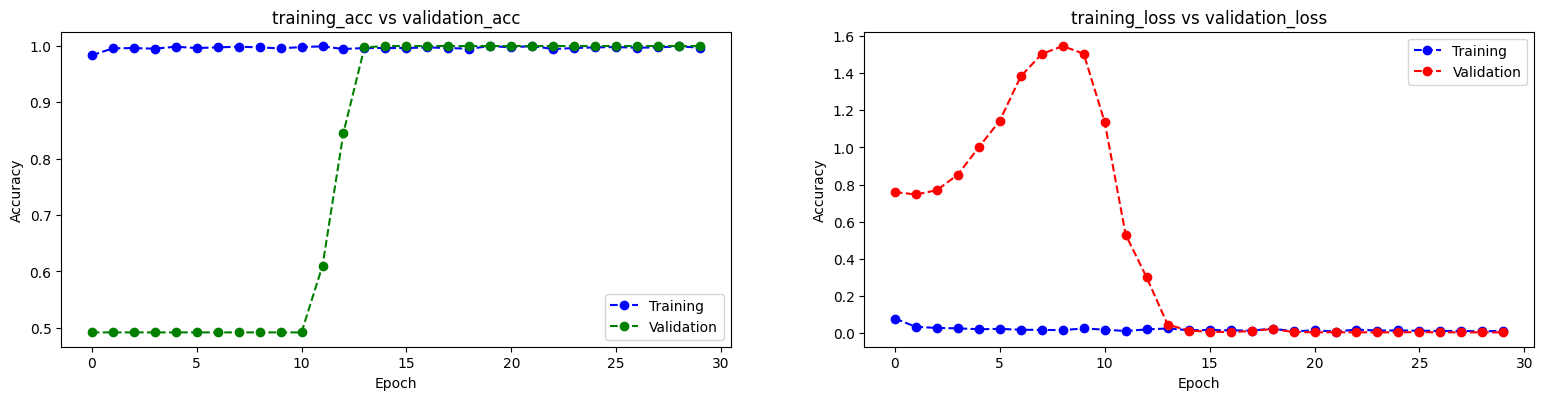

In [19]:
fig = plt.figure(figsize=(19,9))
plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--')
plt.plot(history.history['val_accuracy'], 'go--')
plt.title("training_acc vs validation_acc")
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(222)
plt.plot(history.history['loss'],'bo--')
plt.plot(history.history['val_loss'],'ro--')
plt.title("training_loss vs validation_loss")
plt.legend(['Training', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [17]:
testing = cnn.evaluate(test_x, test_y)
predictions = cnn.predict(test_x)
pred_y = np.argmax(predictions, axis = 1)
test_y = np.argmax(test_y, axis=1)
print(classification_report(test_y,pred_y))

17/17 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       267
           1       1.00      1.00      1.00       261

    accuracy                           1.00       528
   macro avg       1.00      1.00      1.00       528
weighted avg       1.00      1.00      1.00       528



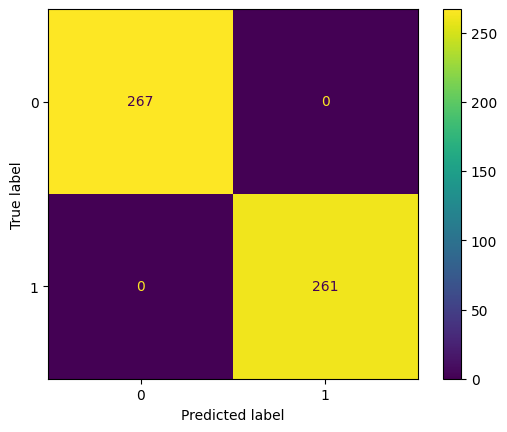

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_y, pred_y))
disp.plot()
plt.show()